In [ ]:
!git clone -b dev https://github.com/jegorus/diplom.git
%cd ./diplom/

!chmod +x ./scripts/dependencies.sh
!bash ./scripts/dependencies.sh

Cloning into 'diplom'...
remote: Enumerating objects: 1359, done.
remote: Counting objects: 100% (1148/1148), done.
remote: Compressing objects: 100% (1000/1000), done.
remote: Total 1359 (delta 309), reused 325 (delta 148), pack-reused 211
Receiving objects: 100% (1359/1359), 6.57 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (363/363), done.
/content/diplom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-1

In [ ]:
%cd /content/diplom/

from config import Config
from model import ModelHandler
from convert import Converter
import pandas as pd

model_handler = ModelHandler(Config.Dataset.RTE, Config.Model.FULLFT)

/content/diplom


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/content/diplom/model.py:23: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.metric = load_metric(*self.dataset_handler.dataset_name)


The repository for glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/glue.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
df_comparison_results = pd.DataFrame(columns=['name', 'test_acc', 'test_f1', 'eval_acc', 'eval_f1', 'params', 'time', 'dataset', 'seed'])

In [ ]:
ia3_config = dict(
    peft_type="IA3",
    task_type="SEQ_CLS",
    target_modules=["query", "value", "key", =["attention.dense", "output.dense"],
    feedforward_modules=["attention.dense", "output.dense"],
)

adalora_config = dict(
    peft_type="ADALORA",
    task_type="SEQ_CLS",
    tinit=50,
    lora_alpha=32,
    target_modules=["query", "value", "key", "attention.output.dense", "intermediate.dense", "output.dense"],
    lora_dropout=0.1,
)

lora_config = dict(
    r=16,
    lora_alpha=16,
    target_modules=(["value", "intermediate.dense"]),
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
    task_type="SEQ_CLS"
)



In [ ]:

training_args = dict(
  load_best_model_at_end=True,
  metric_for_best_model="f1",
  output_dir="lora_output",
  logging_dir='lora_logs',
  logging_strategy="steps",
  evaluation_strategy="steps",
  save_total_limit=1,
  save_steps=200,
  save_only_model=True,

  warmup_steps=200,
  weight_decay=0.01,

  learning_rate=5e-5,
  num_train_epochs=0.01,
  logging_steps=50,
  eval_steps=50,
  logging_first_step=True,
  per_device_eval_batch_size=16,
  per_device_train_batch_size=16,

)


trainer = model_handler.run_experiments_and_convert(
    training_args,
    seeds=[10],
    convert_name='eval-rte-fullft',
    convert_nums=[0],
    print_params=True,
    # saved_model_path = './my_model'
  )



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta.embeddings.word_embeddings.weight
roberta.embeddings.position_embeddings.weight
roberta.embeddings.token_type_embeddings.weight
roberta.embeddings.LayerNorm.weight
roberta.embeddings.LayerNorm.bias
roberta.encoder.layer.0.attention.self.query.weight
roberta.encoder.layer.0.attention.self.query.bias
roberta.encoder.layer.0.attention.self.key.weight
roberta.encoder.layer.0.attention.self.key.bias
roberta.encoder.layer.0.attention.self.value.weight
roberta.encoder.layer.0.attention.self.value.bias
roberta.encoder.layer.0.attention.output.dense.weight
roberta.encoder.layer.0.attention.output.dense.bias
roberta.encoder.layer.0.attention.output.LayerNorm.weight
roberta.encoder.layer.0.attention.output.LayerNorm.bias
roberta.encoder.layer.0.intermediate.dense.weight
roberta.encoder.layer.0.intermediate.dense.bias
roberta.encoder.layer.0.output.dense.weight
roberta.encoder.layer.0.output.dense.bias
roberta.encoder.layer.0.output.LayerNorm.weight
roberta.encoder.layer.0.output.LayerNorm

Step,Training Loss,Validation Loss


0 converted


In [ ]:
val_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["validation"])
val_eval

{'eval_loss': 0.6972050666809082,
 'eval_accuracy': 0.4729241877256318,
 'train_runtime': 217.4074,
 'epoch': 0.01282051282051282}

In [ ]:
test_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["test"])
test_eval

IndexError: Target -1 is out of bounds.

In [ ]:
df_comparison_results = pd.DataFrame(columns=['name', 'test_acc', 'test_f1', 'eval_acc', 'eval_f1', 'params', 'time', 'dataset', 'seed'])

In [ ]:
df_new_row = Converter.csv_to_pandas_name("exp-eval-cb-fullft-0")
df_new_row = Converter.prettify_results(df_new_row)



new_row = {'name':'fullft',
           'test_acc': round(test_eval['eval_accuracy'], 4),
           'test_f1': round(test_eval['eval_f1'], 4),
           'eval_acc': round(val_eval['eval_accuracy'], 4),
           'eval_f1': round(val_eval['eval_f1'], 4),
           'time': round(df_new_row.iloc[len(df_new_row) - 1]['train_runtime'], 4),
           'dataset':'cb',
           'seed': 10}

df_comparison_results.loc[len(df_comparison_results)] = new_row
df_comparison_results

In [ ]:
!chmod +x ./scripts/clear_logs.sh
!bash ./scripts/clear_logs.sh

In [ ]:
model_handler = ModelHandler(Config.Dataset.CB, Config.Model.LORA)

In [ ]:
lora_config = dict(
    r=16,
    lora_alpha=16,
    target_modules=(["value", "intermediate.dense"]),
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
    task_type="SEQ_CLS"
)


training_args = dict(
  load_best_model_at_end=True,
  metric_for_best_model="f1",
  output_dir="lora_output",
  logging_dir='lora_logs',
  logging_strategy="steps",
  evaluation_strategy="steps",
  save_total_limit=1,
  save_steps=30,
  save_only_model=True,

  warmup_steps=50,
  weight_decay=0.01,

  learning_rate=7e-4,
  num_train_epochs=20,
  logging_steps=10,
  eval_steps=10,
  logging_first_step=True,
  per_device_eval_batch_size=16,
  per_device_train_batch_size=16,

)


trainer = model_handler.run_experiments_and_convert(
    training_args,
    seeds=[10],
    convert_name='eval-cb-lora',
    convert_nums=[0],
    print_params=True,
    adapter_config=lora_config,
    # saved_model_path = './my_model'
  )



In [ ]:
val_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["validation"])
val_eval

{'eval_loss': 0.6520600914955139,
 'eval_accuracy': 0.8823529411764706,
 'eval_f1': 0.9169550173010381,
 'train_runtime': 465.2024,
 'epoch': 10.0}

In [ ]:
test_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["test"])
test_eval

{'eval_loss': 0.6614448428153992,
 'eval_accuracy': 0.8805797101449275,
 'eval_f1': 0.9129332206255283,
 'train_runtime': 473.4799,
 'epoch': 10.0}

In [ ]:
df_new_row = Converter.csv_to_pandas_name("exp-eval-cb-lora-0")
df_new_row = Converter.prettify_results(df_new_row)



new_row = {'name':'lora',
           'test_acc': round(test_eval['eval_accuracy'], 4),
           'test_f1': round(test_eval['eval_f1'], 4),
           'eval_acc': round(val_eval['eval_accuracy'], 4),
           'eval_f1': round(val_eval['eval_f1'], 4),
           'time': round(df_new_row.iloc[len(df_new_row) - 1]['train_runtime'], 4),
           'dataset': 'cb',
           'seed': 10}

df_comparison_results.loc[len(df_comparison_results)] = new_row
df_comparison_results

,name,test_acc,test_f1,eval_acc,eval_f1,params,time,seed
0,fullft,0.8632,0.8977,0.8848,0.9168,NaN,673.9921,12
1,lora,0.8806,0.9129,0.8824,0.9170,NaN,463.2137,12


In [ ]:
!chmod +x ./scripts/clear_logs.sh
!bash ./scripts/clear_logs.sh

In [ ]:
Converter.pandas_to_csv_name(df_comparison_results, "df_comparison_results_cb_10")

In [ ]:
model_handler = ModelHandler(Config.Dataset.MRPC, Config.Model.IA3)

In [ ]:
ia3_config = dict(
    peft_type="IA3",
    task_type="SEQ_CLS",
    target_modules=["query", "value", "key", "attention.dense", "output.dense"],
    feedforward_modules=["attention.dense", "output.dense"],
)



training_args = dict(
  load_best_model_at_end=True,
  metric_for_best_model="f1",
  output_dir="lora_output",
  logging_dir='lora_logs',
  logging_strategy="steps",
  evaluation_strategy="steps",
  save_total_limit=1,
  save_steps=200,
  save_only_model=True,

  warmup_steps=200,
  weight_decay=0.01,

  learning_rate=5e-3,
  num_train_epochs=10,
  logging_steps=50,
  eval_steps=50,
  logging_first_step=True,
  per_device_eval_batch_size=16,
  per_device_train_batch_size=16,

)


trainer = model_handler.run_experiments_and_convert(
    training_args,
    seeds=[12],
    convert_name='eval-mrpc-ia3',
    convert_nums=[2],
    print_params=True,
    adapter_config=ia3_config,
    # saved_model_path = './my_model'
  )



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


base_model.model.roberta.encoder.layer.0.attention.self.query.ia3_l.default
base_model.model.roberta.encoder.layer.0.attention.self.key.ia3_l.default
base_model.model.roberta.encoder.layer.0.attention.self.value.ia3_l.default
base_model.model.roberta.encoder.layer.0.attention.output.dense.ia3_l.default
base_model.model.roberta.encoder.layer.0.output.dense.ia3_l.default
base_model.model.roberta.encoder.layer.1.attention.self.query.ia3_l.default
base_model.model.roberta.encoder.layer.1.attention.self.key.ia3_l.default
base_model.model.roberta.encoder.layer.1.attention.self.value.ia3_l.default
base_model.model.roberta.encoder.layer.1.attention.output.dense.ia3_l.default
base_model.model.roberta.encoder.layer.1.output.dense.ia3_l.default
base_model.model.roberta.encoder.layer.2.attention.self.query.ia3_l.default
base_model.model.roberta.encoder.layer.2.attention.self.key.ia3_l.default
base_model.model.roberta.encoder.layer.2.attention.self.value.ia3_l.default
base_model.model.roberta.encod

Step,Training Loss,Validation Loss,Accuracy,F1,Runtime
50,0.716100,0.621950,0.683824,0.812227,9.955600
100,0.639100,0.543883,0.713235,0.822458,19.680200
150,0.529700,0.497673,0.784314,0.858521,29.521200
200,0.552100,0.707881,0.752451,0.845329,39.799900
250,0.452400,0.418194,0.816176,0.862385,49.962200
300,0.470800,0.566364,0.713235,0.826152,59.849200
350,0.432200,0.609970,0.740196,0.773504,69.591100
400,0.470600,0.363391,0.840686,0.885362,79.269000
450,0.479400,0.547312,0.683824,0.812227,89.466800
500,0.412200,0.490398,0.838235,0.891803,99.060800


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

2 converted


In [ ]:
val_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["validation"])
val_eval


{'eval_loss': 0.4620489478111267,
 'eval_accuracy': 0.8799019607843137,
 'eval_f1': 0.9129662522202486,
 'train_runtime': 458.4308,
 'epoch': 10.0}

In [ ]:
test_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["test"])
test_eval

{'eval_loss': 0.47473734617233276,
 'eval_accuracy': 0.8747826086956522,
 'eval_f1': 0.90625,
 'train_runtime': 466.3477,
 'epoch': 10.0}

In [ ]:
df_new_row = Converter.csv_to_pandas_name("exp-eval-mrpc-ia3-2")
df_new_row = Converter.prettify_results(df_new_row)



new_row = {'name':'ia3',
           'test_acc': round(test_eval['eval_accuracy'], 4),
           'test_f1': round(test_eval['eval_f1'], 4),
           'eval_acc': round(val_eval['eval_accuracy'], 4),
           'eval_f1': round(val_eval['eval_f1'], 4),
           'time': round(df_new_row.iloc[len(df_new_row) - 1]['train_runtime'], 4),
           'seed': 12}

df_comparison_results.loc[len(df_comparison_results)] = new_row
df_comparison_results

,name,test_acc,test_f1,eval_acc,eval_f1,params,time,seed
0,fullft,0.8632,0.8977,0.8848,0.9168,NaN,673.9921,12
1,lora,0.8806,0.9129,0.8824,0.9170,NaN,463.2137,12
2,ia3,0.8748,0.9062,0.8799,0.9130,NaN,456.5422,12


In [ ]:
Converter.pandas_to_csv_name(df_comparison_results, "df_comparison_results_mrpc_12")

In [ ]:
model_handler = ModelHandler(Config.Dataset.MRPC, Config.Model.ADALORA)

In [ ]:
!chmod +x ./scripts/clear_logs.sh
!bash ./scripts/clear_logs.sh

In [ ]:
adalora_config = dict(
    peft_type="ADALORA",
    task_type="SEQ_CLS",
    tinit=50,
    lora_alpha=32,
    target_modules=["query", "value", "key", "attention.output.dense", "intermediate.dense", "output.dense"],
    lora_dropout=0.1,
)


training_args = dict(
  load_best_model_at_end=True,
  metric_for_best_model="f1",
  output_dir="lora_output",
  logging_dir='lora_logs',
  logging_strategy="steps",
  evaluation_strategy="steps",
  save_total_limit=1,
  save_steps=200,
  save_only_model=True,

  warmup_steps=200,
  weight_decay=0.01,

  learning_rate=2e-3,
  num_train_epochs=10,
  logging_steps=50,
  eval_steps=50,
  logging_first_step=True,
  per_device_eval_batch_size=16,
  per_device_train_batch_size=16,

)


trainer = model_handler.run_experiments_and_convert(
    training_args,
    seeds=[12],
    convert_name='eval-mrpc-adalora',
    convert_nums=[2],
    print_params=True,
    adapter_config=adalora_config,
    # saved_model_path = './my_model'
  )



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_E.default
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_E.default
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_E.default
base_model.model.roberta.encoder.layer.0.attention.output.dense.lora_A.default
base_model.model.roberta.encoder.layer.0.attention.output.dense.lora_B.default
base_model.model.roberta.encoder.layer.0.attention.output.dense.lora_E.default
base_model.model.roberta.encoder.layer.0.intermediate.dense.lora_A.default
b

Step,Training Loss,Validation Loss,Accuracy,F1,Runtime
50,1.543600,1.047949,0.683824,0.812227,14.730600
100,0.744700,0.637695,0.683824,0.812227,29.192100
150,0.656600,0.626197,0.720588,0.788104,43.438100
200,0.621200,0.556872,0.794118,0.863636,58.090200
250,0.596100,0.428994,0.818627,0.862454,72.593600
300,0.516000,0.456043,0.843137,0.879245,87.075100
350,0.523800,0.408327,0.833333,0.870722,101.498900
400,0.461800,0.417878,0.865196,0.900542,116.102500
450,0.486000,0.404752,0.857843,0.902357,131.069900
500,0.425200,0.358105,0.852941,0.896194,145.500400


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

2 converted


In [ ]:
val_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["validation"])
val_eval


{'eval_loss': 0.5759008526802063,
 'eval_accuracy': 0.8946078431372549,
 'eval_f1': 0.9252173913043479,
 'train_runtime': 671.3101,
 'epoch': 10.0}

In [ ]:
test_eval = trainer.evaluate(eval_dataset=model_handler.dataset_handler.tokenized_dataset["test"])
test_eval

{'eval_loss': 0.5844888091087341,
 'eval_accuracy': 0.8869565217391304,
 'eval_f1': 0.9177562210037958,
 'train_runtime': 681.2449,
 'epoch': 10.0}

In [ ]:
df_new_row = Converter.csv_to_pandas_name("exp-eval-mrpc-adalora-2")
df_new_row = Converter.prettify_results(df_new_row)



new_row = {'name':'adalora',
           'test_acc': round(test_eval['eval_accuracy'], 4),
           'test_f1': round(test_eval['eval_f1'], 4),
           'eval_acc': round(val_eval['eval_accuracy'], 4),
           'eval_f1': round(val_eval['eval_f1'], 4),
           'time': round(df_new_row.iloc[len(df_new_row) - 1]['train_runtime'], 4),
           'seed': 12}

df_comparison_results.loc[len(df_comparison_results)] = new_row
df_comparison_results

,name,test_acc,test_f1,eval_acc,eval_f1,params,time,seed
0,fullft,0.8632,0.8977,0.8848,0.9168,NaN,673.9921,12
1,lora,0.8806,0.9129,0.8824,0.9170,NaN,463.2137,12
2,ia3,0.8748,0.9062,0.8799,0.9130,NaN,456.5422,12
3,adalora,0.8870,0.9178,0.8946,0.9252,NaN,668.8849,12


In [ ]:
Converter.pandas_to_csv_name(df_comparison_results, "df_comparison_results_mrpc_12")

In [ ]:
path = "./my_model"
trainer.save_model(path)
# !zip -r ./my_model.zip ./my_model

updating: my_model/ (stored 0%)
updating: my_model/merges.txt (deflated 53%)
updating: my_model/model.safetensors (deflated 12%)
updating: my_model/special_tokens_map.json (deflated 52%)
updating: my_model/tokenizer_config.json (deflated 76%)
updating: my_model/vocab.json (deflated 59%)
updating: my_model/config.json (deflated 51%)
updating: my_model/training_args.bin (deflated 51%)
updating: my_model/tokenizer.json (deflated 72%)
  adding: my_model/adapter_model.safetensors (deflated 7%)
  adding: my_model/adapter_config.json (deflated 52%)
  adding: my_model/README.md (deflated 66%)


# Дополнительные ячейки

In [ ]:
%cd /content/diplom/results/experiments/

/content/diplom/results/experiments


In [ ]:
df_max = Converter.create_df_max()

for i in range(180, 194):
  df_max = Converter.add_row_to_df_max(df_max, 'lora', i)

for i in range(0, 5):
  df_max = Converter.add_row_to_df_max(df_max, 'fullft', i)

for i in range(5, 29):
  df_max = Converter.add_row_to_df_max(df_max, 'mrpc-fullft', i)

for i in range(0, 180):
  df_max = Converter.add_row_to_df_max(df_max, 'lora', i)

for i in range(0, 54):
  df_max = Converter.add_row_to_df_max(df_max, 'cb-fullft', i)

for i in range(0, 81):
  df_max = Converter.add_row_to_df_max(df_max, 'cb-lora', i)

for i in range(0, 14):
  df_max = Converter.add_row_to_df_max(df_max, 'mrpc-ia3', i)
df_max

,name,max_acc,max_f1,max_avg,epoch_max_acc,epoch_max_f1,epoch_max_avg
0,exp-lora-180,0.867647,0.902878,0.885262,7.608696,7.608696,7.608696
1,exp-lora-181,0.852941,0.893617,0.873279,7.608696,7.608696,7.608696
2,exp-lora-182,0.870098,0.905861,0.887980,6.413043,7.391304,7.391304
3,exp-lora-183,0.877451,0.911661,0.894556,4.239130,8.695652,8.695652
4,exp-lora-184,0.882353,0.916084,0.899218,5.760870,5.760870,5.760870
5,exp-lora-185,0.882353,0.913978,0.898166,5.978261,5.978261,5.978261
6,exp-lora-186,0.901961,0.929329,0.915645,7.500000,7.500000,7.500000
7,exp-lora-187,0.904412,0.930233,0.917322,5.326087,5.326087,5.326087
8,exp-lora-188,0.897059,0.925267,0.911163,4.456522,4.456522,4.456522
9,exp-lora-189,0.897059,0.925000,0.911029,5.217391,5.217391,5.217391


In [ ]:
df_info_to_target_m_cb_mapper = Converter.create_df_info_to_results_mapper()

In [ ]:
df_info_lr = pd.DataFrame(columns=["name", "exp-type", "dataset", "lr", "warmup_steps", 'weight_decay', "seed" ])

In [ ]:
for lr in [5e-4, 5e-5, 2e-5]:

  new_column = {
      "name": "exp-cb-fullft-" + str(len(df_info_lr)),
      "exp-type": "fullft",
      "dataset": "cb",
      "lr": lr,
      "warmup_steps": 0,
      "weight_decay": 0.2,
      "seed": 42,
  }
  df_info_lr.loc[len(df_info_lr)] = new_column
  new_column["seed"] = 1
  new_column["name"] = "exp-cb-fullft-" + str(len(df_info_lr))
  df_info_lr.loc[len(df_info_lr)] = new_column

df_info_lr

,name,exp-type,dataset,lr,warmup_steps,weight_decay,seed
0,exp-cb-fullft-0,fullft,cb,0.00050,200,0.01,42
1,exp-cb-fullft-1,fullft,cb,0.00050,200,0.01,1
2,exp-cb-fullft-2,fullft,cb,0.00005,200,0.01,42
3,exp-cb-fullft-3,fullft,cb,0.00005,200,0.01,1
4,exp-cb-fullft-4,fullft,cb,0.00002,200,0.01,42
5,exp-cb-fullft-5,fullft,cb,0.00002,200,0.01,1
6,exp-cb-fullft-6,fullft,cb,0.00005,100,0.01,42
7,exp-cb-fullft-7,fullft,cb,0.00005,100,0.01,1
8,exp-cb-fullft-8,fullft,cb,0.00002,100,0.01,42
9,exp-cb-fullft-9,fullft,cb,0.00002,100,0.01,1


In [ ]:
df_cb_lr = pd.DataFrame(index=[0, 0.01, 0.05, 0.1, 0.2], columns=[0, 50, 100, 200])

In [ ]:
df_tmp_lr = df_info_lr.loc[df_info_lr["lr"] == 5e-5].loc[df_info_lr["seed"] == 1]
for _, row in df_tmp_lr.iterrows():
  df_cb_lr.loc[row["weight_decay"]][row["warmup_steps"]] = round(float(df_max.loc[df_max["name"] == row["name"]]["max_f1"]), 3)

df_cb_lr

<ipython-input-103-0c1a3f21631a>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_cb_lr.loc[row["weight_decay"]][row["warmup_steps"]] = round(float(df_max.loc[df_max["name"] == row["name"]]["max_f1"]), 3)


,0,50,100,200
0.00,0.96,0.892,NaN,NaN
0.01,0.905,0.923,0.937,0.961
0.05,NaN,0.974,NaN,NaN
0.10,NaN,0.974,NaN,NaN
0.20,0.96,NaN,NaN,NaN


In [ ]:
import numpy as np
df_cb_lr.loc[0.2][50] = df_cb_lr.loc[0.2][0]
df_cb_lr.loc[0.2][0] = np.NaN
df_cb_lr

,0,50,100,200
0.00,0.222,0.545,NaN,NaN
0.01,0.222,0.497,0.548,0.647
0.05,NaN,0.487,NaN,NaN
0.10,NaN,0.487,NaN,NaN
0.20,NaN,0.487,NaN,NaN


In [ ]:
df_info_to_target_m_cb_mapper = Converter.csv_to_pandas_name("into_to_target_m_cb_mapper")
df_info_to_target_m_cb_mapper

,name,i_begin,i_end,seeds_list
0,exp-lora-q-v,271,272,42
1,exp-lora-q-v-k,303,305,"[42, 1]"
2,exp-lora-q,305,307,"[42, 1]"
3,exp-lora-v,307,309,"[42, 1]"
4,exp-lora-k,309,311,"[42, 1]"
5,exp-lora-q-k,311,313,"[42, 1]"
6,exp-lora-v-k,313,315,"[42, 1]"
7,exp-lora-q-v-k-attff,315,317,"[42, 1]"
8,exp-lora-all-layers,317,319,"[42, 1]"


In [ ]:
df_info_to_target_m_cb_mapper = Converter.add_row_to_df_info_to_results_mapper(df_info_to_target_m_cb_mapper, "exp-lora-q-v", 319, 321, [42, 1])
df_info_to_target_m_cb_mapper

,name,i_begin,i_end,seeds_list
0,exp-lora-q-v,271,272,42
1,exp-lora-q-v-k,303,305,"[42, 1]"
2,exp-lora-q,305,307,"[42, 1]"
3,exp-lora-v,307,309,"[42, 1]"
4,exp-lora-k,309,311,"[42, 1]"
5,exp-lora-q-k,311,313,"[42, 1]"
6,exp-lora-v-k,313,315,"[42, 1]"
7,exp-lora-q-v-k-attff,315,317,"[42, 1]"
8,exp-lora-all-layers,317,319,"[42, 1]"
9,exp-lora-q-v,319,321,"[42, 1]"


In [ ]:
df_info_to_target_m_cb_mapper

,name,i_begin,i_end,seeds_list
1,exp-lora-q-v-k,303,305,"[42, 1]"
2,exp-lora-q,305,307,"[42, 1]"
3,exp-lora-v,307,309,"[42, 1]"
4,exp-lora-k,309,311,"[42, 1]"
5,exp-lora-q-k,311,313,"[42, 1]"
6,exp-lora-v-k,313,315,"[42, 1]"
7,exp-lora-q-v-k-attff,315,317,"[42, 1]"
8,exp-lora-all-layers,317,319,"[42, 1]"
9,exp-lora-q-v,319,321,"[42, 1]"


In [ ]:
24

In [ ]:
Converter.pandas_to_csv_name(df_info_to_target_m_cb_mapper, "info_to_target_m_cb_mapper")

In [ ]:
df_exp_results = Converter.create_df_exp_results()

for _, row in df_info_to_target_m_cb_mapper.iterrows():

  df_exp_results = Converter.add_row_to_df_exp_results(df_max, df_exp_results, row["name"], int(row["i_begin"]) + 24, int(row["i_begin"]) + 26, 42)


In [ ]:
df_exp_results

,name,acc_avg,f1_avg,both_avg,acc_max,f1_max,both_max,seeds_list,epoch_acc_avg,epoch_f1_avg,epoch_both_avg
0,exp-lora-q-v-k,0.946429,0.960479,0.953454,0.946429,0.960724,0.953576,42,10.9375,11.25,11.25
1,exp-lora-q,0.866071,0.871476,0.868774,0.892857,0.891443,0.89215,42,14.0625,14.0625,14.0625
2,exp-lora-v,0.973214,0.968565,0.97089,0.982143,0.986745,0.984444,42,13.125,14.375,14.375
3,exp-lora-k,0.919643,0.940627,0.930135,0.928571,0.947531,0.938051,42,11.25,11.25,11.25
4,exp-lora-q-k,0.901786,0.886997,0.894391,0.910714,0.907949,0.909332,42,14.0625,14.0625,14.0625
5,exp-lora-v-k,0.946429,0.910541,0.928485,0.946429,0.930209,0.938319,42,12.8125,12.8125,12.8125
6,exp-lora-q-v-k-attff,0.955357,0.951906,0.953631,0.964286,0.973602,0.968944,42,11.5625,14.375,14.375
7,exp-lora-all-layers,0.991071,0.993424,0.992248,1.0,1.0,1.0,42,9.6875,9.6875,9.6875
8,exp-lora-q-v,0.9375,0.927184,0.932342,0.946429,0.93694,0.941684,42,11.25,12.5,12.5


In [ ]:
metric = "f1_avg"
df_exp_results2 = df_exp_results[["name", metric]].sort_values(by=metric, ascending=False)
df_exp_results2[metric] = df_exp_results2[metric].apply((lambda x: round(x, 4)))
df_exp_results2[["name", metric]]

,name,f1_avg
7,exp-lora-all-layers,0.9934
2,exp-lora-v,0.9686
0,exp-lora-q-v-k,0.9605
6,exp-lora-q-v-k-attff,0.9519
3,exp-lora-k,0.9406
8,exp-lora-q-v,0.9272
5,exp-lora-v-k,0.9105
4,exp-lora-q-k,0.8870
1,exp-lora-q,0.8715


In [ ]:
metric = "f1_avg"
df_exp_results2 = df_exp_results[["name", metric]].sort_values(by=metric, ascending=False)
df_exp_results2[metric] = df_exp_results2[metric].apply((lambda x: round(x, 4)))
df_exp_results2[["name", metric]]

,name,f1_avg
8,exp-lora-all-layers,1.0000
7,exp-lora-q-v-k-attff,0.9736
1,exp-lora-q-v-k,0.9602
3,exp-lora-v,0.9504
4,exp-lora-k,0.9475
0,exp-lora-q-v,0.9174
6,exp-lora-v-k,0.8909
5,exp-lora-q-k,0.8660
2,exp-lora-q,0.8515


In [ ]:
df_ra = pd.DataFrame(index=["r1", "r2", "r4", "r8", "r16", "r32", "r64", "r128"], columns=["a1", "a2", "a4", "a8", "a16", "a32", "a64", "a128"])


In [ ]:
metric = "max_acc"
first_exp = 239

i = 0
for r in [1, 2, 4, 8, 16, 32, 64]:
  for a in [1, 2, 4, 8, 16, 32, 64]:
    df_ra.loc["r" + str(r)]["a" + str(a)] = round(df_max.iloc[first_exp + i][metric], 3)
    i += 1

for r in [128]:
   for a in [1, 2, 4, 8, 16, 32, 64, 128]:
      df_ra.loc["r" + str(r)]["a" + str(a)] = round(df_max.iloc[first_exp + i][metric], 3)
      i += 1

for r in [1, 2, 4, 8, 16, 32, 64]:
   for a in [128]:
      df_ra.loc["r" + str(r)]["a" + str(a)] = round(df_max.iloc[first_exp + i][metric], 3)
      i += 1

df_ra

,a1,a2,a4,a8,a16,a32,a64,a128
r1,0.911,0.964,0.964,0.946,0.929,0.946,0.946,0.929
r2,0.946,0.929,0.946,0.929,0.946,0.911,0.929,0.946
r4,0.946,0.946,0.946,0.929,0.946,0.964,0.929,0.929
r8,0.946,0.946,0.929,0.911,0.929,0.964,0.929,0.946
r16,0.946,0.964,0.929,0.946,0.929,0.929,0.946,0.946
r32,0.946,0.946,0.929,0.946,0.964,0.929,0.946,0.946
r64,0.946,0.964,0.946,0.946,0.946,0.929,0.946,0.911
r128,0.946,0.946,0.946,0.946,0.964,0.946,0.929,0.929


In [ ]:
import numpy as np

df_ra.apply(np.max, axis=0).apply((lambda x: round(x, 3)))

a1      0.919
a2      0.927
a4      0.923
a8      0.927
a16     0.932
a32     0.939
a64     0.936
a128    0.932
dtype: float64

In [ ]:
import re

for _, row in df_exp_results.iterrows():

  m = re.match(r'exp-lora-(r\d?\d?\d?)-(a\d?\d?\d?)', row["name"])
  if m is not None:
    df_ra.loc[m.group(1)][m.group(2)] = round(row["epoch_f1_avg"], 3)

df_ra

,a1,a2,a4,a8,a16,a32,a64,a128
r1,8.045,7.283,7.23,8.475,5.54,8.859,8.261,0.272
r2,7.228,4.35,5.545,5.27,6.25,8.967,5.543,2.011
r4,8.043,6.25,8.64,4.675,8.59,6.685,2.88,5.489
r8,6.848,6.96,8.045,6.685,7.985,8.26,6.465,8.152
r16,7.935,7.445,7.99,8.64,6.415,6.085,6.74,7.01
r32,7.989,8.75,8.37,7.665,5.435,4.89,5.325,0.11
r64,8.859,5.87,6.359,7.34,5.87,6.36,7.99,7.715
r128,7.065,7.283,9.293,9.185,5.545,7.665,8.48,6.36


In [ ]:
def f1_colorer(val):

    color = 'white'
    if val <= 5: color = '#04cc3d'
    elif val <= 6: color = '#02e619'
    elif val <= 7: color = '#9ef705'
    elif val <= 8: color = '#dbf705'
    elif val <= 9: color = '#f7e305'
    elif val <= 10: color = '#f7bb05'
    else: color = 'red'
    if val <= 3: color = 'red'
    return 'background-color: %s' % color

df_ra.style.format('{:.3f}').applymap(f1_colorer)

,a1,a2,a4,a8,a16,a32,a64,a128
r1,8.045,7.283,7.230,8.475,5.540,8.859,8.261,0.272
r2,7.228,4.350,5.545,5.270,6.250,8.967,5.543,2.011
r4,8.043,6.250,8.640,4.675,8.590,6.685,2.880,5.489
r8,6.848,6.960,8.045,6.685,7.985,8.260,6.465,8.152
r16,7.935,7.445,7.990,8.640,6.415,6.085,6.740,7.010
r32,7.989,8.750,8.370,7.665,5.435,4.890,5.325,0.110
r64,8.859,5.870,6.359,7.340,5.870,6.360,7.990,7.715
r128,7.065,7.283,9.293,9.185,5.545,7.665,8.480,6.360


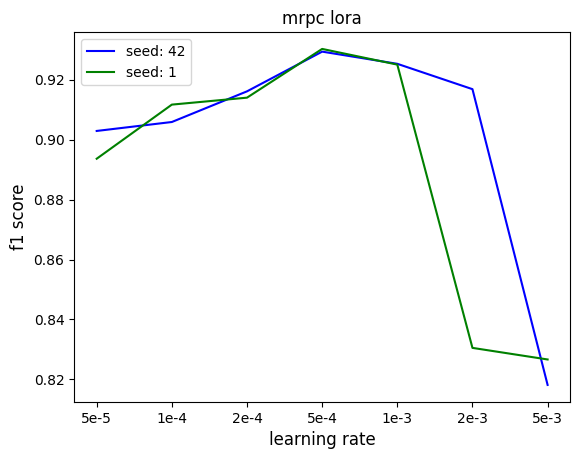

In [ ]:
import matplotlib.pyplot as plt


i = 0
df_max_m = df_max["max_f1"]
l1 = [df_max_m.iloc[i], df_max_m.iloc[i + 2], df_max_m.iloc[i + 4], df_max_m.iloc[i + 6], df_max_m.iloc[i + 8], df_max_m.iloc[i + 10], df_max_m.iloc[i + 12]]

i = 1
l2 = [df_max_m.iloc[i], df_max_m.iloc[i + 2], df_max_m.iloc[i + 4], df_max_m.iloc[i + 6], df_max_m.iloc[i + 8], df_max_m.iloc[i + 10], df_max_m.iloc[i + 12]]

plt.plot(l1, color='blue', label='seed: 42')
plt.plot(l2, color='green', label='seed: 1')
plt.ylabel('f1 score', fontsize=12)
plt.xlabel('learning rate', fontsize=12)
plt.title("mrpc lora")

plt.legend()
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=["5e-5", "1e-4", "2e-4", "5e-4", "1e-3", "2e-3", "5e-3"])
plt.show()

,name,max_acc,max_f1,max_avg,epoch_max_acc,epoch_max_f1,epoch_max_avg
0,exp-fullft-0,0.882353,0.915078,0.898472,3.480000,2.070000,3.480000
1,exp-fullft-1,0.906863,0.932143,0.919503,5.540000,5.540000,5.540000
2,exp-fullft-2,0.892157,0.923077,0.907617,4.350000,4.350000,4.350000
3,exp-fullft-3,0.887255,0.917857,0.902556,3.260000,3.260000,3.260000
4,exp-fullft-4,0.882353,0.914286,0.898319,4.670000,8.910000,8.910000
5,exp-mrpc_fullft-5,0.696078,0.812227,0.753238,0.108696,0.217391,0.108696
6,exp-mrpc_fullft-6,0.727941,0.819512,0.773727,0.217391,0.217391,0.217391
7,exp-mrpc_fullft-7,0.683824,0.812227,0.748025,0.108696,0.108696,0.108696
8,exp-mrpc_fullft-8,0.762255,0.839394,0.800429,0.217391,0.326087,0.217391
9,exp-mrpc_fullft-9,0.835784,0.886248,0.861016,0.760870,0.760870,0.760870


In [ ]:
i = 1
df_max_m = df_max["max_f1"]
l2 = [df_max_m.iloc[i + 5], df_max_m.iloc[i + 7], df_max_m.iloc[i + 9], df_max_m.iloc[i], df_max_m.iloc[i + 11], df_max_m.iloc[i + 13], df_max_m.iloc[i + 15]]

In [ ]:
df_mrpc_fullft = pd.DataFrame(index=["0", "0.01", "0.05", "0.1", "0.2"], columns=["0", "200", "500"])